In [1]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputMastersFolder = inputFolder + r"\masters"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

In [3]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          emailAttendeesText = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          emailAttendeesList = emailAttendeesText.split("; ")
          for emailAttendee in emailAttendeesList:
            if emailAttendee not in attendees:
              attendees.append(emailAttendee)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

def readCsv(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def getMissingValues(df):
  percentMissing = df.isnull().sum() * 100 / len(df)
  missingValueDf = pd.DataFrame({'columnName': df.columns, 'percentMissing': percentMissing })
  missingValueDf = missingValueDf.sort_values('percentMissing', ascending=False).reset_index(drop=True)
  display(missingValueDf)

In [4]:
def readAndWritePreprocessedData(preprocessedData, masters):
  ## Decisiones propias para el modelo

  # Transformar la data a dataframe
  df = pd.DataFrame(preprocessedData)

  for i in range(0, len(masters)):
    masters[i] = pd.DataFrame(masters[i])

  # Eliminar los campos que ya no se usarán
  columnsToDelete = [
    "candidatePostulationDate", "jobId", "candidateFullName", "candidateDocumentNumber", "candidateBirthDate", "candidateAddress", "candidateHomeNumber", "candidateCellphoneNumber", "candidateEmail", "workObjetive", "lastWorkDays", "lastWorkDescription", "lastEducationDays", "yearsOfExperience", "yearsOfStudy"
  ]
  # El tema con las ultimas 2 es que puede ser 0 cuando hay o no data de experiencia y educacion, reemplazar el NaN desde el comienzo en el dataframe (understanding)
  df = df.drop(columns=columnsToDelete)

  # Aplicar las equivalencias a los campos: jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName
  equivalences = ["jobProfileName", "lastWorkCompany", "lastWorkArea", "lastWorkName", "lastEducationCompany", "lastEducationArea", "lastEducationName"]

  # Mejorar las equivalencias poco a poco
  for index, equivalence in enumerate(equivalences):
    df = pd.merge(df, masters[index], on=equivalence)
    df[equivalence] = df["equivalence"]
    df = df.drop(columns=["equivalence", "count", "equals"])

  ## Decisiones por la metodología

  # Analisis de valores nulos
  # Reemplazando las cadenas vacias a NaN
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  for column in categoricalColumns:
    df[column] = df[column].replace('',None,regex = True).astype("object")

  # Reemplazando los ceros a NaN
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].replace(0,None).astype('float64')

  # Obteniendo el porcentaje de nulos por columna
  getMissingValues(df)
  
  # Tecnica 1: Eliminar la columna si sobrepasa el 30% de nulos
  # Al ninguno superar el 30% de nulos, no se eliminará ninguna columna

  # Tecnica 2: Reemplazar NaN por aleatorizacion de valores no nulos, para variables categoricas
  np.random.seed(0)

  for column in categoricalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else np.random.choice(df[column].dropna().tolist()))

  # Tecnica 3: Reemplazar NaN por el promedio de valores no nulos, para variables numericas
  for column in numericalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else round(float(df[column].dropna().mean()), 1) )

  # Obteniendo el nuevo porcentaje de nulos por columna
  getMissingValues(df)

  # Reemplazo de valores atipicos (outliers) (variables numericas)
  # Analizando valores atipicos extremos
  for column in numericalColumns:
    firstQuartil, thirdQuartil = np.percentile(df[column], 25), np.percentile(df[column], 75)
    interQuartilRange = thirdQuartil - firstQuartil
    bottomLimit, topLimit = firstQuartil - 3*interQuartilRange, thirdQuartil + 3*interQuartilRange

    # Reemplazando los valores
    df[column] = df[column].map(lambda x: bottomLimit if x < bottomLimit else x)
    df[column] = df[column].map(lambda x: topLimit if x > topLimit else x)

  # Regresando el dataframe a array de dicts
  preprocessedData = df.to_dict('records')

  writeJson(preprocessedData, os.path.join(outputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(outputFolder, 'result.csv'), 'utf-8')

  writeJson(preprocessedData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return preprocessedData

In [5]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.dtypes)
  print(df.count())

  columns = [columnName for columnName in df.columns]
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]

  for column in columns:
    if column in numericalColumns:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()
    else:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()

In [6]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  isPreprocessed = False

  # Leyendo la data obtenida en el entendimiento de los datos
  bumeranData = readJson(os.path.join(inputMainFolder, 'result.json'))
  
  # Leyendo archivos maestros
  jobProfileName = readCsv(os.path.join(inputMastersFolder, 'jobProfileName.csv'))
  lastWorkCompany = readCsv(os.path.join(inputMastersFolder, 'lastWorkCompany.csv'))
  lastWorkArea = readCsv(os.path.join(inputMastersFolder, 'lastWorkArea.csv'))
  lastWorkName = readCsv(os.path.join(inputMastersFolder, 'lastWorkName.csv'))
  lastEducationCompany = readCsv(os.path.join(inputMastersFolder, 'lastEducationCompany.csv'))
  lastEducationArea = readCsv(os.path.join(inputMastersFolder, 'lastEducationArea.csv'))
  lastEducationName = readCsv(os.path.join(inputMastersFolder, 'lastEducationName.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(outputFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(bumeranData, [jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-23 02:23:15.108447
Se inició el procesamiento


,columnName,percentMissing
0,otherSkills,23.198044
1,technicalSkills,11.931540
2,languages,7.550122
3,candidateCivilStatus,6.092910
4,lastWorkCompany,5.574572
5,lastWorkArea,5.496333
6,lastWorkName,5.496333
7,worksNumber,5.496333
8,lastWorkCountry,5.496333
9,salary,4.146699


,columnName,percentMissing
0,jobProfileName,0.0
1,lastEducationCountry,0.0
2,otherSkills,0.0
3,languages,0.0
4,technicalSkills,0.0
5,studiesNumber,0.0
6,lastEducationDegree,0.0
7,lastEducationStatus,0.0
8,lastEducationName,0.0
9,lastEducationArea,0.0


Se terminó el preprocesamiento
jobProfileName                object
candidateResidenceCountry     object
candidateCivilStatus          object
candidateBirthCountry         object
salary                       float64
lastWorkCompany               object
lastWorkCountry               object
lastWorkArea                  object
lastWorkName                  object
worksNumber                  float64
lastEducationCompany          object
lastEducationCountry          object
lastEducationArea             object
lastEducationName             object
lastEducationStatus           object
lastEducationDegree           object
studiesNumber                float64
technicalSkills              float64
languages                    float64
otherSkills                  float64
hired                          int64
dtype: object
jobProfileName               10225
candidateResidenceCountry    10225
candidateCivilStatus         10225
candidateBirthCountry        10225
salary                       10225
las

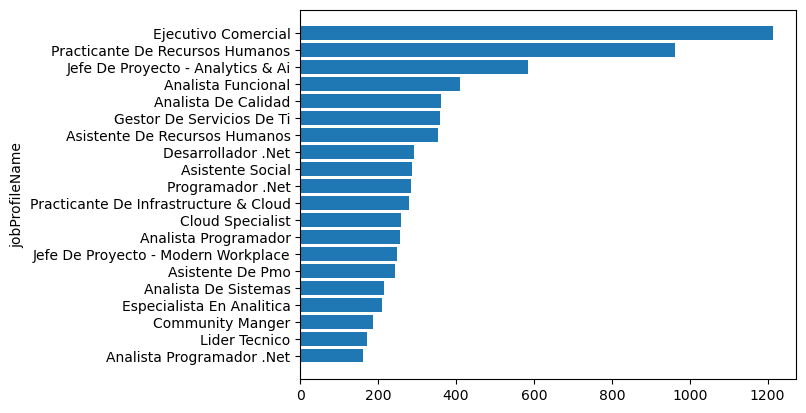

Peru                    10042
Venezuela                 146
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
Espana                      1
Panama                      1
Bolivia                     1
El Salvador                 1
Costa Rica                  1
Francia                     1
Name: candidateResidenceCountry, dtype: int64


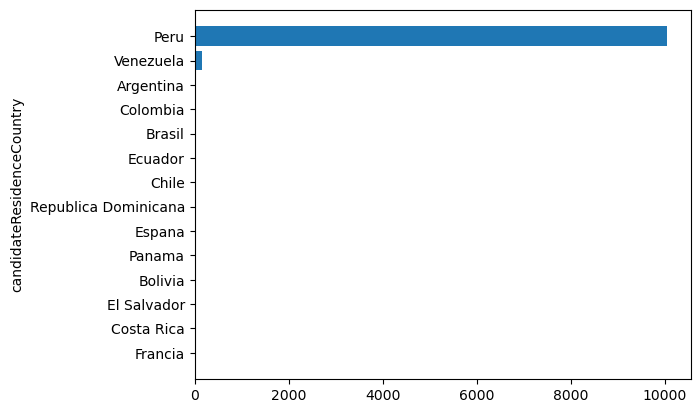

Soltero/A          8350
Casado/A           1578
Divorciado/A        132
Pareja De Hecho     114
Union Libre          48
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


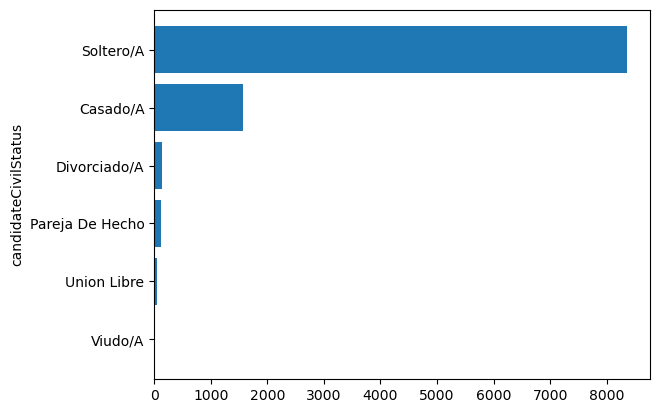

Peru                    10042
Venezuela                 146
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
Espana                      1
Panama                      1
Bolivia                     1
El Salvador                 1
Costa Rica                  1
Francia                     1
Name: candidateBirthCountry, dtype: int64


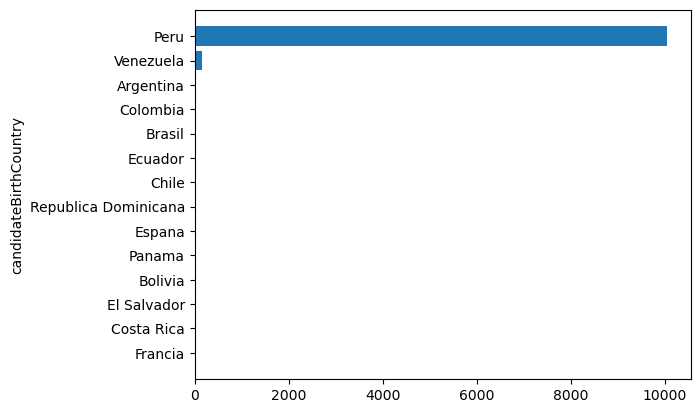

5000.0    617
2500.0    617
2000.0    588
3500.0    562
3000.0    549
4000.0    532
1500.0    472
6000.0    438
4304.8    424
4500.0    405
1200.0    362
1800.0    354
5500.0    302
1025.0    298
7000.0    283
1000.0    282
6500.0    281
930.0     227
8000.0    202
1.0       201
Name: salary, dtype: int64


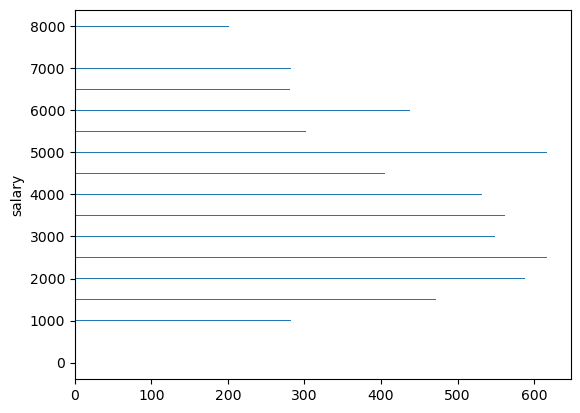

Freelance                                          211
Ntt Data Peru S.A.C.                               182
Canvia S.A.C.                                      164
Mdp Consulting S.A.C.                              120
Manpower Professional Services S.A.                117
Global Hitss Peru S.A.C.                           116
Indra Peru S.A.                                     88
Telefonica Del Peru                                 85
Banco De Credito Del Peru - Bcp                     84
Stefanini It Solutions                              74
Corporacion Sapia S.A.                              57
Tata Consultancy Services                           54
Ferreyros S.A.                                      45
Universidad Peruana De Ciencias Aplicadas (Upc)     44
Tgestiona Sac                                       42
America Movil Peru S.A.C.                           41
Gfi Peru Sac                                        40
Pontificia Universidad Catolica Del Peru            39
Oficina Na

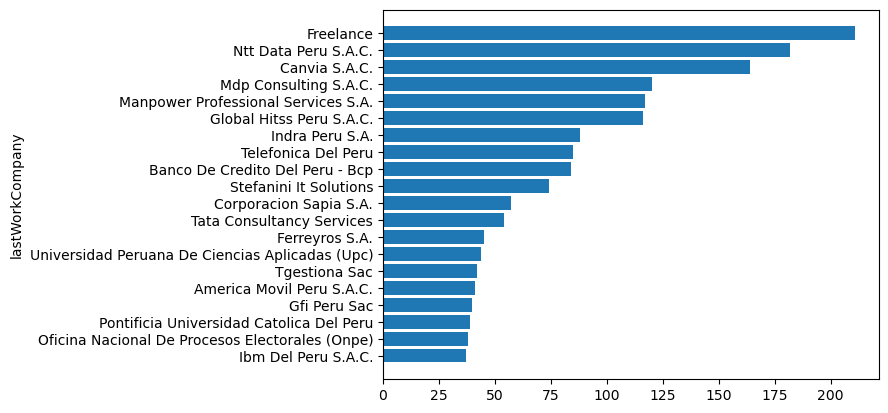

Peru              10040
Estados Unidos       32
Venezuela            26
Espana               24
Brasil               20
Colombia             17
Chile                12
Ecuador               8
Argentina             7
Mexico                4
Costa Rica            3
Reino Unido           3
Francia               3
Paises Bajos          3
Albania               3
Australia             2
Panama                2
Italia                2
Finlandia             2
Pakistan              1
Name: lastWorkCountry, dtype: int64


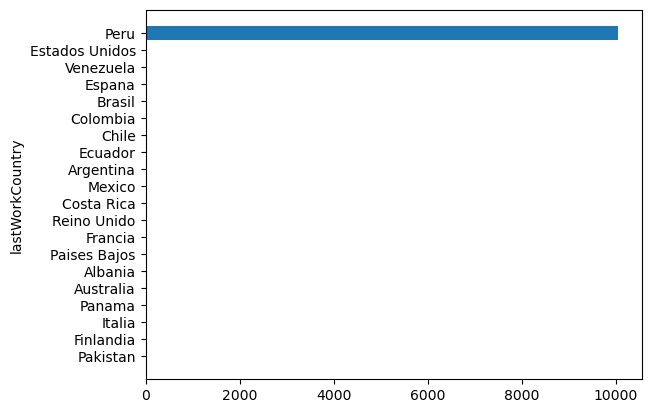

Tecnologia / Sistemas            1109
Tecnologias De La Informacion    1091
Liderazgo De Proyecto             620
Programacion                      619
Comercial                         584
Sistemas                          517
Recursos Humanos                  464
Ventas                            280
Administracion                    272
Analisis De Datos                 248
Analisis Funcional                230
Infraestructura                   227
Soporte Tecnico                   216
Atencion Al Cliente               176
Seguridad Informatica             166
Otras Ingenierias                 162
Desarrollo De Negocios            142
Testing / Qa / Qc                 136
Telecomunicaciones                128
Administracion De Personal        122
Name: lastWorkArea, dtype: int64


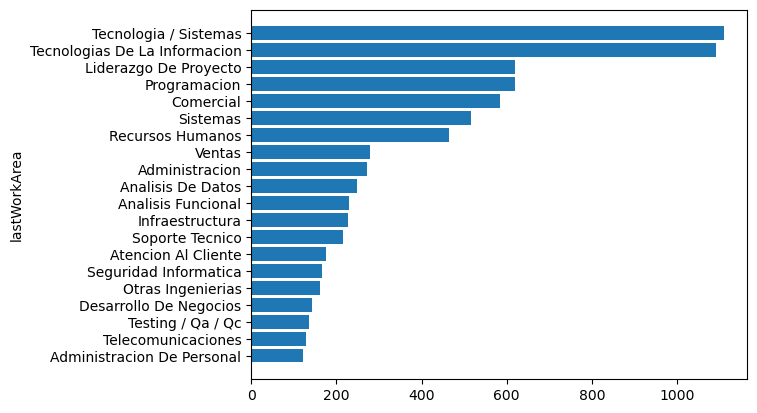

Analista Programador                            568
Analista De Sistemas                            273
Jefe De Proyectos                               179
Analista Funcional                              165
Asistente Administrativo                        111
Trabajadora Social                              106
Analista De Calidad                             104
Ejecutivo Comercial                              95
Asistente De Recursos Humanos                    93
Supervisor De Infraestructura De Redes Cisco     87
Project Manager                                  72
Asesor Comercial                                 69
Lider Tecnico                                    64
Gerente De Proyectos                             61
Soporte Tecnico                                  59
Analista Desarrollador                           56
Practicante                                      55
Practicante De Recursos Humanos                  54
Analista                                         52
Jefe De Sist

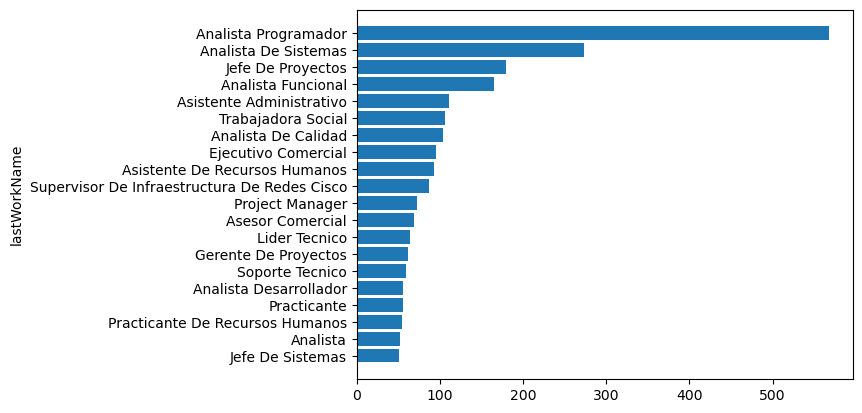

5.0     1300
4.0     1184
6.0     1059
3.0     1021
7.0      935
2.0      740
8.0      735
1.0      663
6.1      562
9.0      530
10.0     407
11.0     274
12.0     238
13.0     152
14.0     119
15.0      91
17.0      60
16.0      45
20.0      43
19.0      37
Name: worksNumber, dtype: int64


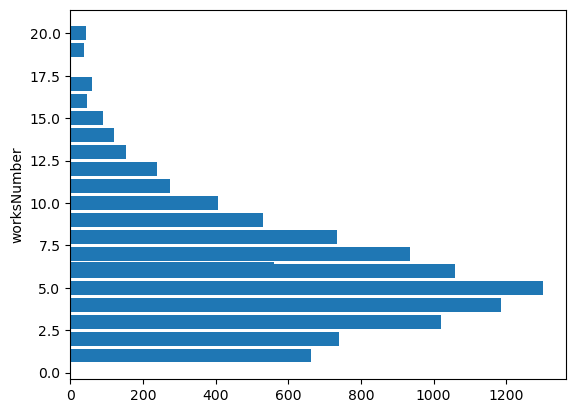

Universidad Peruana De Ciencias Aplicadas    931
Universidad Tecnologica Del Peru             524
Instituto Cibertec                           438
Universidad Privada Del Norte                348
Pontificia Universidad Catolica Del Peru     347
Universidad San Ignacio Del Loyola           329
Universidad Nacional Mayor De San Marcos     328
Universidad Cesar Vallejo                    293
Universidad Esan                             286
Universidad De Lima                          249
Universidad De San Martin De Porres          216
Universidad Nacional De Ingenieria           216
Universidad Ricardo Palma                    189
Universidad Nacional Federico Villarreal     188
Instituto San Ignacio De Loyola              187
Universidad Inca Garcilaso De La Vega        184
Tecsup                                       126
Instituto Superior Tecnologico Idat          118
Universidad Del Pacifico                     107
Universidad Nacional Del Callao              104
Name: lastEducationC

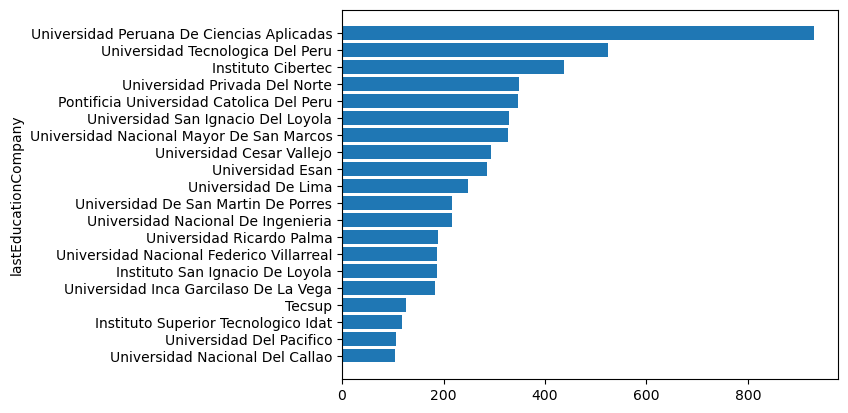

Peru              9601
Espana             199
Venezuela          167
Estados Unidos      79
Mexico              34
Argentina           21
Brasil              20
Colombia            19
Chile               18
Costa Rica          14
Canada               8
Australia            6
Bolivia              6
Ecuador              6
Francia              5
Alemania             3
India                3
Reino Unido          3
Internacional        2
Cuba                 2
Name: lastEducationCountry, dtype: int64


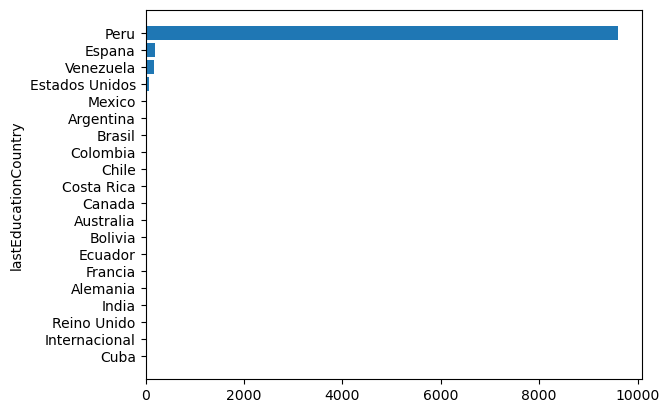

Ing. En Sistemas                  2353
Tecnologias De La Informacion     1263
Adm. De Empresas                  1152
Ing. Informatica                   630
Ing. Industrial                    496
Computacion / Informatica          487
Marketing / Comercializacion       378
Recursos Humanos / Relac. Ind.     364
Psicologia                         353
Otra                               348
Ing. - Otros                       192
Trabajo Social                     145
Analisis De Sistemas               138
Ing. Telecomunicaciones            130
Telecomunicaciones                 123
Programacion                       123
Procesos / Calidad Total           105
Finanzas                            98
Bachiller                           94
Ing. Electronica                    92
Name: lastEducationArea, dtype: int64


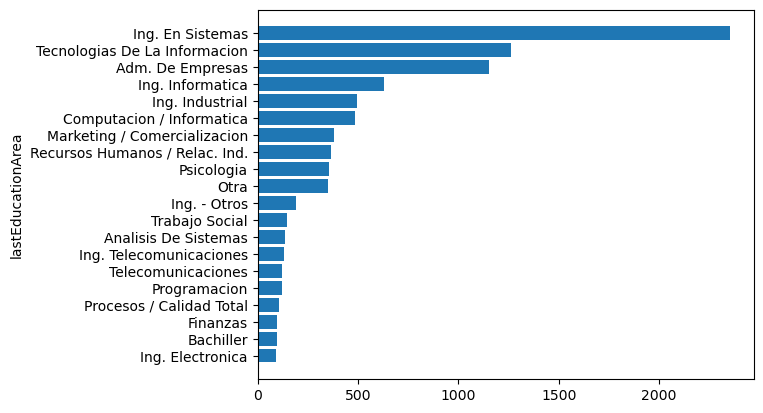

Ingenieria De Sistemas                       1616
Ingenieria Industrial                         338
Psicologia                                    310
Administracion De Empresas                    234
Computacion E Informatica                     183
Mba                                           132
Bachiller En Ingenieria De Sistemas           131
Administracion                                127
Marketing                                     121
Administracion Y Negocios Internacionales      94
Ingles                                         85
Itil                                           76
Gestion De Proyectos                           75
Scrum Master                                   74
Trabajo Social                                 70
Ingenieria De Redes Y Comunicaciones           62
Ingenieria Informatica                         62
Ingenieria De Software                         57
Tecnico En Computacion E Informatica           54
Diplomado En Gestion De Proyectos              49


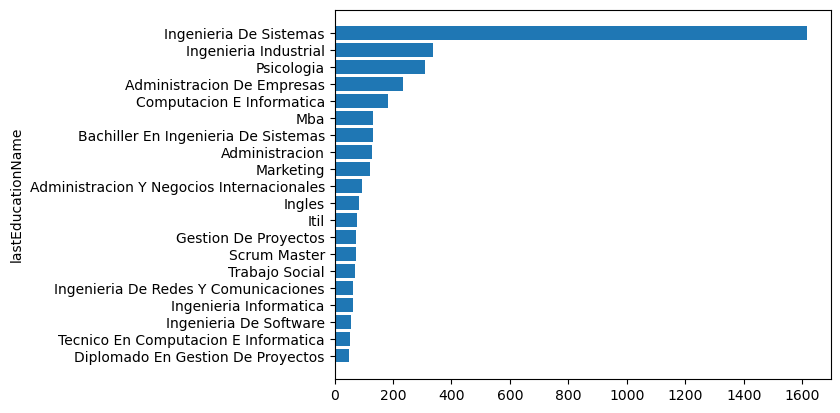

Graduado      6697
En Curso      3359
Abandonado     169
Name: lastEducationStatus, dtype: int64


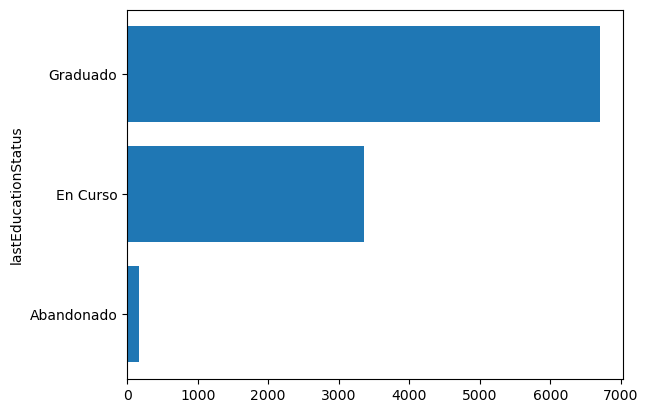

Universitario        5083
Otro                 2299
Posgrado             1195
Terciario/Tecnico    1019
Master                605
Doctorado              13
Secundario             11
Name: lastEducationDegree, dtype: int64


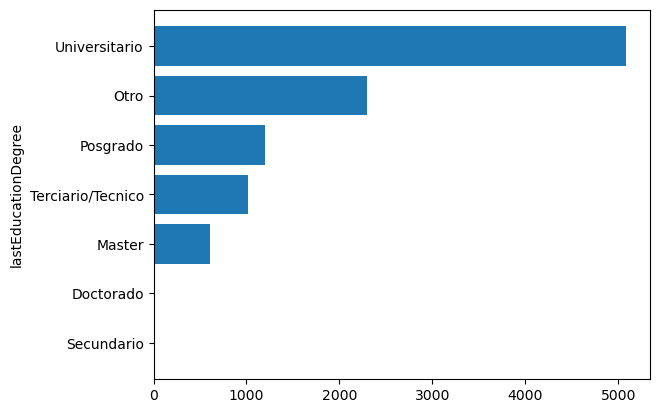

1.0     3820
2.0     2349
3.0     1166
4.0      711
5.0      471
6.0      427
7.0      283
13.0     266
8.0      191
9.0      142
3.2      123
11.0     117
10.0      90
12.0      69
Name: studiesNumber, dtype: int64


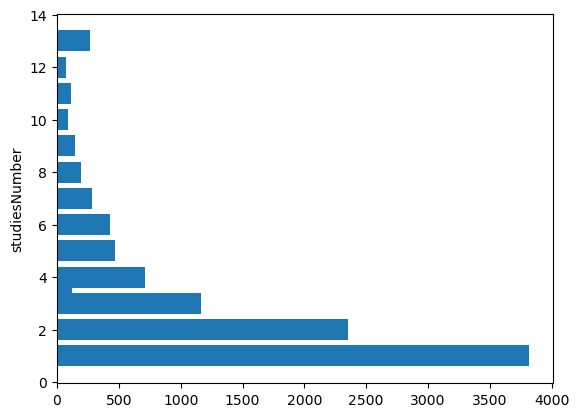

9.3     1220
1.0     1122
3.0      863
2.0      808
4.0      685
5.0      586
6.0      526
7.0      486
9.0      448
8.0      420
11.0     341
10.0     336
35.0     285
12.0     258
13.0     240
16.0     231
14.0     184
15.0     160
17.0     126
18.0     119
Name: technicalSkills, dtype: int64


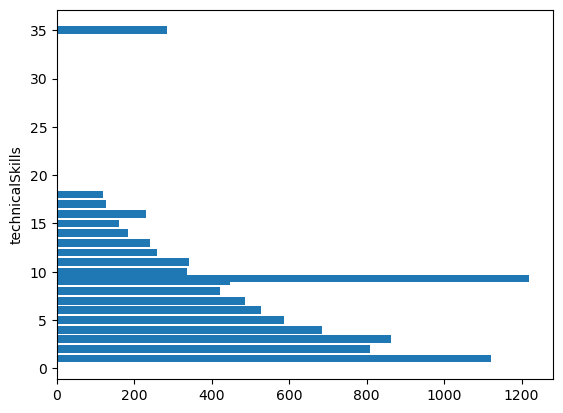

1.0    7122
2.0    1973
1.3     772
2.2     358
Name: languages, dtype: int64


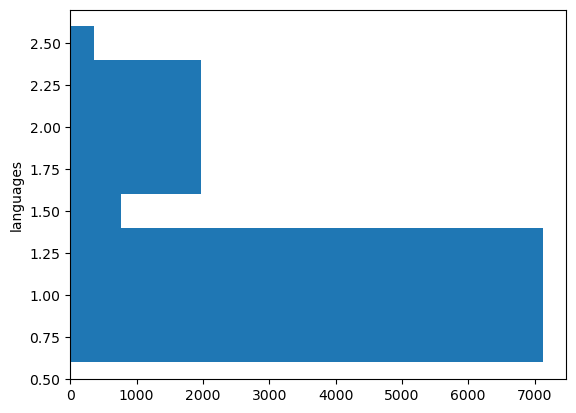

5.3     2372
1.0     1752
2.0     1171
3.0      835
4.0      743
5.0      635
6.0      494
7.0      430
8.0      342
18.0     277
9.0      274
10.0     215
11.0     174
12.0     139
13.0     115
14.0      89
15.0      69
17.0      50
16.0      49
Name: otherSkills, dtype: int64


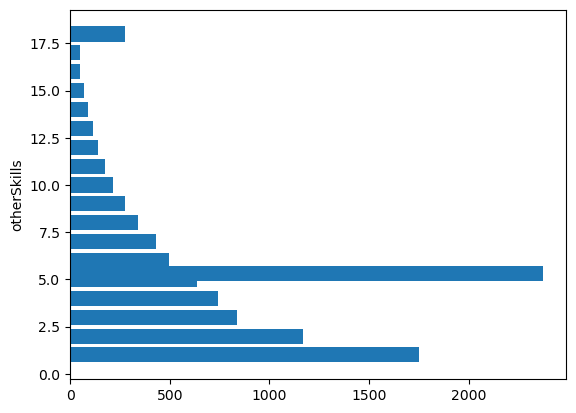

0    9601
1     624
Name: hired, dtype: int64


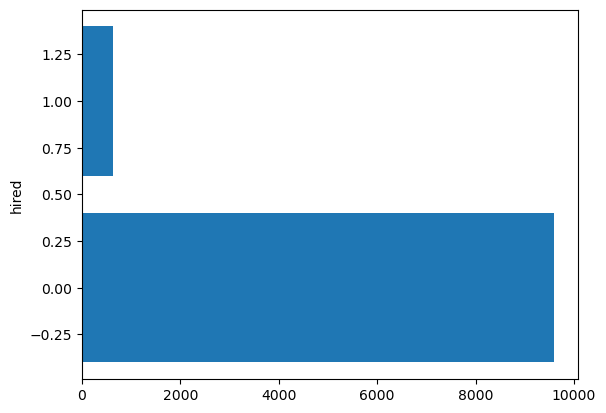

Fin: 2023-05-23 02:23:27.128984
Tiempo: 0:00:12.020537


In [7]:
if __name__ == "__main__":
  main()